In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets evaluate jiwer accelerate torch torchvision Pillow opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 79.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

In [ ]:
import torch
from PIL import Image
import os # For path operations
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator
from datasets import Dataset, DatasetDict, Features, Value
import evaluate
import numpy as np
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define base paths for the dataset
BASE_DATASET_PATH = "/content/drive/MyDrive/Handrwritten_text_recog/Data/iam_words"
WORDS_TXT_PATH = os.path.join(BASE_DATASET_PATH, "words.txt")
IMAGE_BASE_PATH = os.path.join(BASE_DATASET_PATH, "words")

all_image_paths = []
all_texts = []


with open(WORDS_TXT_PATH, "r") as f:
    for line in f:
        if line.startswith("#"):  # Skip comment lines
            continue

        parts = line.strip().split()
        if len(parts) < 9:
            continue

        word_id = parts[0]
        segmentation_status = parts[1]
        text_label = parts[-1] # The actual word is the last part

        if segmentation_status == "ok":
            id_parts = word_id.split('-')
            if len(id_parts) < 2:
                continue

            image_path = os.path.join(IMAGE_BASE_PATH, id_parts[0], f"{id_parts[0]}-{id_parts[1]}", f"{word_id}.png")
            try:
                img_np = np.array(Image.open(image_path).convert("RGB"))
                if img_np.ndim != 3 or img_np.shape[2] != 3 or img_np.shape[0] <= 16 or img_np.shape[1] <= 16: # Check if the image file actually exists
                    continue
                else:
                    all_image_paths.append(image_path)
                    all_texts.append(text_label)
            except Exception as e:
                print(e)
                pass
print(f"Found {len(all_image_paths)} valid word images and labels.")


Looking for words.txt at: /kaggle/input/iam-handwriting-word-database/iam_words/words.txt
Base image directory: /kaggle/input/iam-handwriting-word-database/iam_words/words
Parsing words.txt...
cannot identify image file '/kaggle/input/iam-handwriting-word-database/iam_words/words/a01/a01-117/a01-117-05-02.png'
Found 35391 valid word images and labels.


In [ ]:
# First split: train+validation vs test
train_val_paths, test_paths, train_val_texts, test_texts = train_test_split(
    all_image_paths, all_texts, test_size=0.3, random_state=42, stratify=None # Stratify can be difficult with text
)
# Second split: train vs validation
train_paths, val_paths, train_texts, val_texts = train_test_split(
    train_val_paths, train_val_texts, test_size=0.1, random_state=42 # 0.111 of 0.9 is approx 0.1 of total
)

# The image loading will happen in the preprocessing transform.
train_dataset = Dataset.from_dict({"image_path": train_paths, "text": train_texts})
eval_dataset = Dataset.from_dict({"image_path": val_paths, "text": val_texts})
test_dataset = Dataset.from_dict({"image_path": test_paths, "text": test_texts})

def is_valid_sample(sample):
    try:
        return isinstance(sample['image_path'], str) and \
               os.path.exists(sample['image_path']) and \
               isinstance(sample['text'], str) and \
               len(sample['text'].strip()) > 0
    except:
        return False
train_dataset = train_dataset.filter(is_valid_sample)
eval_dataset = eval_dataset.filter(is_valid_sample)
test_dataset = test_dataset.filter(is_valid_sample)

print(f"Train: {train_dataset}")
print(f"Validation: {eval_dataset}")
print(f"Test: {test_dataset}")

image_column_name = 'image_path'
text_column_name = 'text'

Training samples: 22295
Validation samples: 2478
Test samples: 10618
Dataset splits created:
Train: Dataset({
    features: ['image_path', 'text'],
    num_rows: 22295
})
Validation: Dataset({
    features: ['image_path', 'text'],
    num_rows: 2478
})
Test: Dataset({
    features: ['image_path', 'text'],
    num_rows: 10618
})


Filter:   0%|          | 0/22295 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2478 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10618 [00:00<?, ? examples/s]


After filtering: Number of training samples: 22295
After filtering: Number of validation samples: 2478
After filtering: Number of test samples: 10618


In [ ]:
#load the model
processor = TrOCRProcessor.from_pretrained("/content/drive/MyDrive/Handrwritten_text_recog/T1o")
model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/Handrwritten_text_recog/T2Vi")
model = model.to(device)

In [ ]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:

def transform_examples(examples):
    try:
        images_pil = [Image.open(path).convert("RGB") for path in examples[image_column_name]]
    except Exception as e:
        print(f"Error loading image for paths {examples[image_column_name]}: {e}")
        raise
    texts = examples[text_column_name]

    inputs = processor(images=images_pil, text=texts, padding="max_length", truncation=True, return_tensors="pt")#.to(device)
    if 'input_ids' in inputs:
        inputs['labels'] = inputs['input_ids']
    return inputs

# Apply the transformation
train_dataset.set_transform(transform_examples)
eval_dataset.set_transform(transform_examples)
test_dataset.set_transform(transform_examples)

Using image column: 'image_path', text column: 'text' for preprocessing.


In [ ]:
cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    if isinstance(pred_ids, tuple):
        pred_ids = pred_ids[0]

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer, "wer": wer}

In [ ]:
batch_size = 4
gradient_accumulation_steps = 1

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/Handrwritten_text_recog",
    predict_with_generate=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    fp16=torch.cuda.is_available(),
    num_train_epochs=3,
    learning_rate=5e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="cer",
    greater_is_better=False,
remove_unused_columns=False,
    report_to="none",
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.image_processor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

train_results = trainer.train()

trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()
print("Model, metrics, and state saved.")

/tmp/ipykernel_35/3434504830.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss,Cer,Wer
1,0.082500,0.016197,0.556619,0.639225


/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1667: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in th

# Test

In [ ]:
# !unzip '/content/New Compressed (zipped) Folder (2).zip' -d '/content/file3/'

Archive:  /content/New Compressed (zipped) Folder (2).zip
  inflating: /content/file3/WhatsApp Image 2025-06-24 at 21.19.03_8b96ee3f.jpg  
  inflating: /content/file3/WhatsApp Image 2025-06-24 at 21.19.03_d1518c47.jpg  
  inflating: /content/file3/WhatsApp Image 2025-06-24 at 21.19.04_5a5c60cd.jpg  
  inflating: /content/file3/WhatsApp Image 2025-06-24 at 21.19.04_d8402d13.jpg  
  inflating: /content/file3/WhatsApp Image 2025-06-24 at 21.19.04_31af35d6.jpg  
  inflating: /content/file3/WhatsApp Image 2025-06-24 at 21.19.04_99bf0b14.jpg  
  inflating: /content/file3/WhatsApp Image 2025-06-24 at 21.22.10_d7d16f16.jpg  
  inflating: /content/file3/WhatsApp Image 2025-06-24 at 21.22.48_0181acae.jpg  
  inflating: /content/file3/WhatsApp Image 2025-06-24 at 21.23.19_1516a9bb.jpg  
  inflating: /content/file3/WhatsApp Image 2025-06-24 at 21.23.47_4ec3d552.jpg  
  inflating: /content/file3/WhatsApp Image 2025-06-24 at 21.24.21_1d63b3ea.jpg  


In [ ]:
#Load processor and model
processor = TrOCRProcessor.from_pretrained("/content/drive/MyDrive/Handrwritten_text_recog/New weights/Preproessor weight")
model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/Handrwritten_text_recog/New weights/ViT weight")
model.to('cpu')


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i

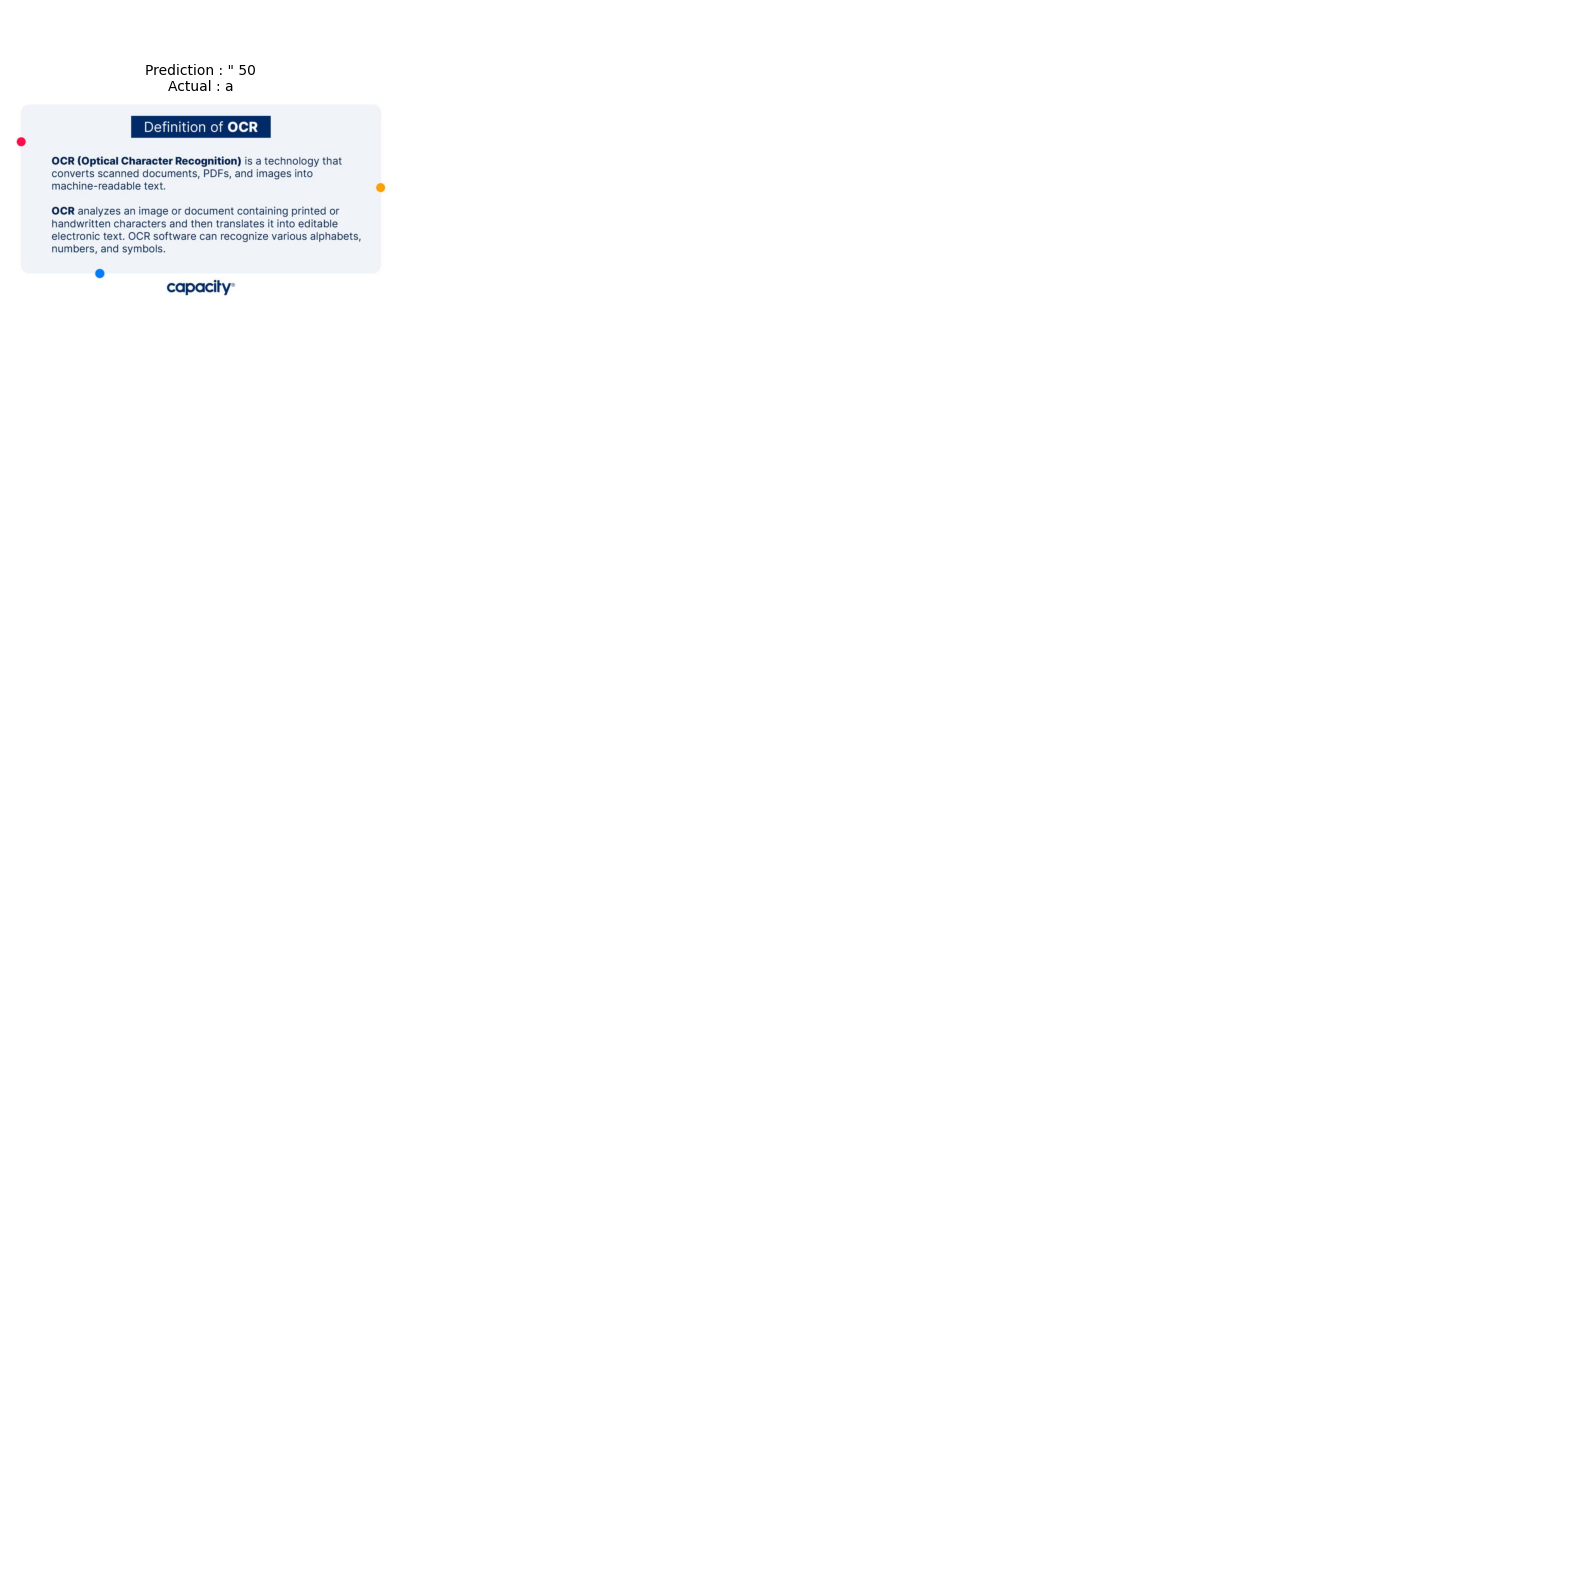

In [ ]:
import matplotlib.pyplot as plt

folder_path = "/content/gg/"
original_text = ['a', 'b', 'c', 'd']

image_files = [f for f in os.listdir(folder_path)]
image_files = image_files[:16]

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.flatten()

for i, image_name in enumerate(image_files):
    img_path = os.path.join(folder_path, image_name)
    image = Image.open(img_path).convert("RGB")

    # Preprocess and predict
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to('cpu')
    generated_ids = model.generate(pixel_values)
    prediction = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    axs[i].imshow(image)
    axs[i].axis('off')
    if i < len(original_text):
      axs[i].set_title("Prediction : {}\nActual : {}".format(prediction, original_text[i]), fontsize=10)
    else:
      axs[i].set_title(prediction, fontsize=10)

for j in range(i + 1, 16):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/Handrwritten_text_recog-20250625T051457Z-1-002.zip', 'r') as zip_ref:
    zip_ref.extractall('new file')


BadZipFile: File is not a zip file